# Laplacian experiment

This is the same code as the laplacian_train.ipynb file.

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set seed
np.random.seed(1)
torch.manual_seed(1)

## Define distribution

In [16]:
dim = 1

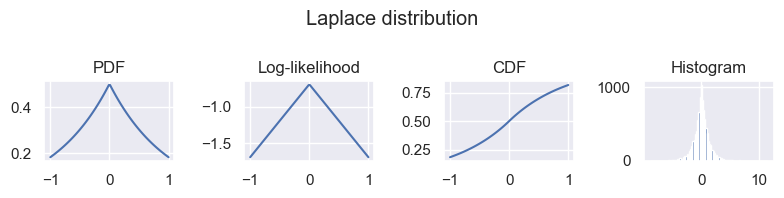

In [17]:
# Sample data points from Laplacian distribution:
# exp(-|x|/b) / (2b)
def sample_laplace(n, b):
    """
    Inputs:
        n: number of points
        b: scale parameter of the Laplacian distribution
    Outputs:
        x: a vector of n points, torch.tensor
    """
    x = torch.distributions.laplace.Laplace(0, b).sample((n,))
    return x


class LaplaceSampler(object):
    def __init__(self, b):
        self.b = b

    def __call__(self, n):
        return sample_laplace(n, self.b)


b = 1.0
dist = torch.distributions.laplace.Laplace(0, b)
x = LaplaceSampler(b)(10000)
# plot pdf, log-likelihood, cdf
plt.rcParams["figure.figsize"] = (8, 2)
x = torch.linspace(-1, 1, 100)
plt.subplot(1, 4, 1)
plt.plot(x, dist.log_prob(x).exp())
plt.title("PDF")
plt.subplot(1, 4, 2)
plt.plot(x, dist.log_prob(x))
plt.title("Log-likelihood")
plt.subplot(1, 4, 3)
plt.plot(x, dist.cdf(x))
plt.title("CDF")
plt.subplot(1, 4, 4)
plt.hist(sample_laplace(10000, b), bins=100)
plt.title("Histogram")
plt.suptitle("Laplace distribution")
plt.tight_layout()

In [18]:
# Add noise to the data
def add_noise(x, sigma=0.1):
    """
    Inputs:
        x: a vector of n points, torch.tensor
        sigma: standard deviation of the noise
    Outputs:
        x: a vector of n points, torch.tensor
    """
    noise = torch.randn_like(x) * sigma
    return x + noise

In [19]:
# parameters for laplace distribution
b = 1
sigma_noise = 1.0
sampler = LaplaceSampler(b)

Text(0.5, 1.0, 'Example training points')

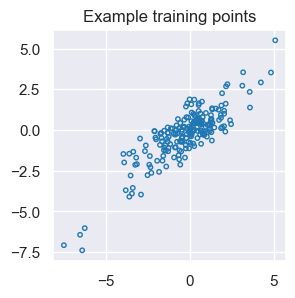

In [20]:
# example training points
target = sampler(200).unsqueeze(1)
input = add_noise(target, sigma_noise)
plt.rcParams["figure.figsize"] = (3, 3)
plt.scatter(input, target, s=10, facecolors="none", edgecolors="tab:blue")
plt.grid("on")
plt.title("Example training points")

### Plot function

In [21]:
# function to plot learned prox, convex function, original function
def plot_all(model):
    xi = np.linspace(-4, 4, 1000)

    y = prox(xi, model)
    c = cvx(xi, model)
    p = prior(xi, model)

    plt.rcParams["figure.figsize"] = (8, 3)

    # learned prox
    plt.subplot(1, 3, 1)
    plt.plot(xi, y, "-", ms=5, label="LPN")
    plt.plot(xi, soft_thr(xi), "--", label="soft thr.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # convex function
    plt.subplot(1, 3, 2)
    plt.plot(xi, c - c.min(), "-", ms=5, label="Cvx func")
    plt.plot(xi, gt_cvx(xi), "--", label="ref.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # original function
    plt.subplot(1, 3, 3)
    plt.plot(xi, p - p.min(), label="LPN")
    plt.plot(xi, np.abs(xi), "--", label=r"$\ell_1$", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Original func")

    plt.tight_layout()

## Define loss

Text(0.5, 1.0, 'exp loss')

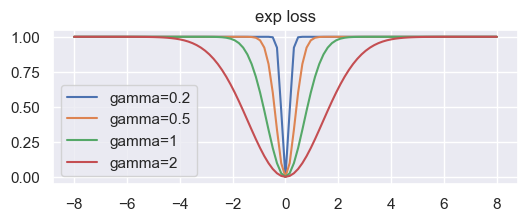

In [22]:
# proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1


# visualize the loss at different sigma
plt.rcParams["figure.figsize"] = (6, 2)
x = torch.linspace(-8, 8, 101)
for gamma_exp_loss in [0.2, 0.5, 1, 2]:
    plt.plot(x, exp_func(x, gamma_exp_loss), label="gamma=" + str(gamma_exp_loss))
plt.legend()
plt.grid("on")
plt.title("exp loss")

## Model parameters

In [23]:
beta = 10  # beta of softplus
hidden = 50  # number of hidden units
layers = 4  # number of layers

# create a model
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
print(
    "Number of parameters in ICNN",
    sum(p.size().numel() for p in lpn_model.parameters()),
)

Number of parameters in ICNN 10502


## Training function

In [24]:
def single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss=None):
    target = sampler(bsize).unsqueeze(1)
    input = add_noise(target, sigma_noise)
    
    input, target = input.to(device), target.to(device)
    out = lpn_model(input)

    if loss_type == 2:
        loss = (out - target).pow(2).sum() / bsize  # MSE loss
    elif loss_type == 1:
        loss = (out - target).abs().sum() / bsize  # MAE loss
    elif loss_type == 0:
        loss = exp_func(out - target, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss

iteration 0 loss 1.8206255435943604
iteration 0 loss 18.46721839904785
iteration 500 loss 1.3207753896713257
iteration 1000 loss 0.9839813709259033
iteration 1500 loss 0.9790367484092712
iteration 2000 loss 0.9244794845581055
iteration 2500 loss 0.8209794759750366
iteration 3000 loss 0.7230926752090454
iteration 3500 loss 0.6889854073524475
iteration 4000 loss 0.6748584508895874
iteration 4500 loss 0.663939893245697
iteration 5000 loss 0.6418311595916748
iteration 5500 loss 0.6267200708389282
iteration 6000 loss 0.6113994121551514
iteration 6500 loss 0.6514428853988647
iteration 7000 loss 0.6272854208946228
iteration 7500 loss 0.6111202836036682
iteration 8000 loss 0.5979729294776917
iteration 8500 loss 0.6183955669403076
iteration 9000 loss 0.6287060976028442
iteration 9500 loss 0.6097391843795776
mse 5.344110488891602
mse 3.638723134994507
mse 1.9828518629074097
mse 0.7643046379089355
mse 0.1847415417432785
mse 0.03884474188089371
mse 0.010565494187176228
mse 0.0027935770340263844
ms

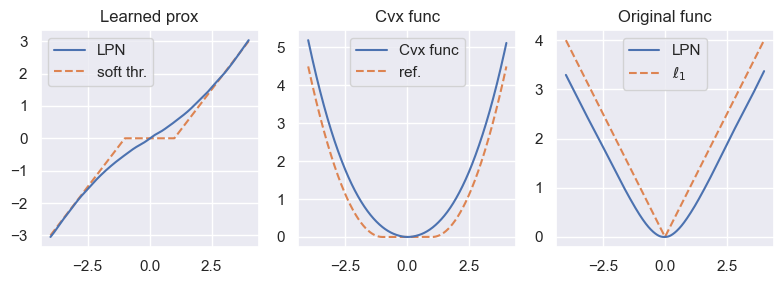

In [25]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
bsize = 2000

for i in range(1):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

L1 loss

iteration 0 loss 1.2023749351501465
iteration 500 loss 0.6162778735160828
iteration 1000 loss 0.6042025685310364
iteration 1500 loss 0.6097608804702759
iteration 2000 loss 0.6148138046264648
iteration 2500 loss 0.628761351108551
iteration 3000 loss 0.6145132184028625
iteration 3500 loss 0.628146767616272
iteration 4000 loss 0.641949474811554
iteration 4500 loss 0.6177706718444824
iteration 5000 loss 0.624915599822998
iteration 5500 loss 0.6242783665657043
iteration 6000 loss 0.62385094165802
iteration 6500 loss 0.6127541661262512
iteration 7000 loss 0.6087161898612976
iteration 7500 loss 0.6132732629776001
iteration 8000 loss 0.6292990446090698
iteration 8500 loss 0.6137698292732239
iteration 9000 loss 0.6229090690612793
iteration 9500 loss 0.6245454549789429
iteration 0 loss 0.5951123833656311
iteration 500 loss 0.6435191035270691
iteration 1000 loss 0.6408283114433289
iteration 1500 loss 0.6210001707077026
iteration 2000 loss 0.613248348236084
iteration 2500 loss 0.6224192976951599
i

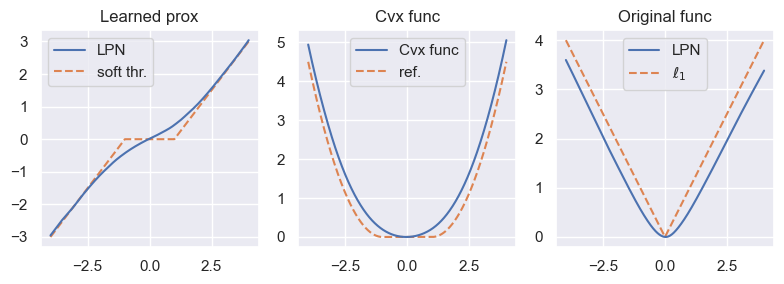

In [26]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
bsize = 2000

for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=1)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=1)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

## Proximal matching loss

We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma=0.5

iteration 0 loss 0.7267063856124878
iteration 500 loss 0.5683502554893494
iteration 1000 loss 0.5684525966644287
iteration 1500 loss 0.5619562268257141
iteration 0 loss 0.5716231465339661
iteration 500 loss 0.5653278231620789
iteration 1000 loss 0.587553083896637
iteration 1500 loss 0.5757136940956116
mse 5.344022750854492
mse 4.157816410064697
mse 1.5456621646881104
mse 0.39022204279899597
mse 0.08642680943012238
mse 0.01805061660706997
mse 0.003864551894366741
mse 0.00082757807103917
mse 0.00017851659504231066
mse 3.624690361903049e-05
final mse 6.732267593179131e-06
(1000,) (1000,) (1000,) (1000,)


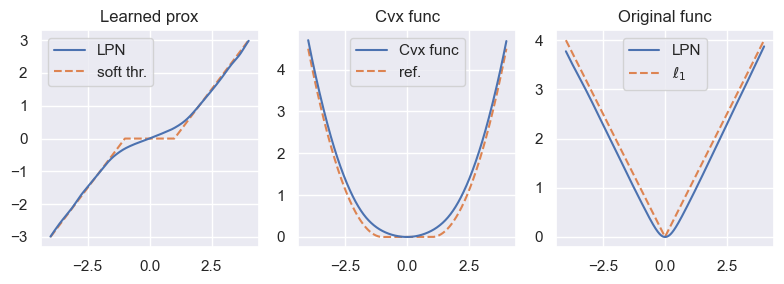

In [27]:
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

bsize = 2000
loss_type = 0
gamma_loss = 0.5

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-3

for i in range(2000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(2000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.4

iteration 0 loss 0.6229897737503052
iteration 500 loss 0.6363795399665833
iteration 1000 loss 0.6430368423461914
iteration 1500 loss 0.6433598399162292
iteration 2000 loss 0.6364691257476807
iteration 2500 loss 0.6482293605804443
iteration 3000 loss 0.6373005509376526
iteration 3500 loss 0.6545844674110413
mse 5.344086170196533
mse 4.268257141113281
mse 1.3210655450820923
mse 0.3930433690547943
mse 0.07850388437509537
mse 0.015073447488248348
mse 0.003124805400148034
mse 0.0007195118232630193
mse 0.0001847083040047437
mse 5.249060632195324e-05
final mse 1.603365126356948e-05
(1000,) (1000,) (1000,) (1000,)


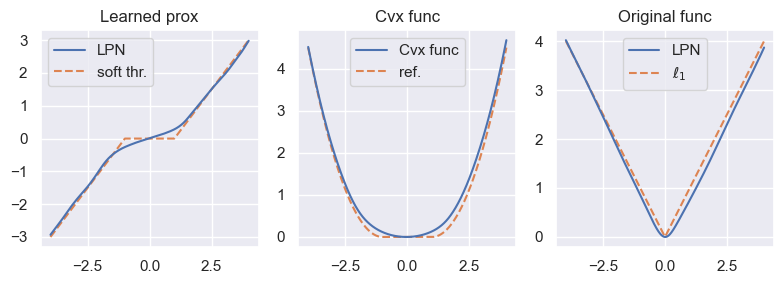

In [28]:
gamma_loss = 0.4

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.3

iteration 0 loss 0.7226693034172058
iteration 500 loss 0.7219579815864563
iteration 1000 loss 0.7211997509002686
iteration 1500 loss 0.7180452346801758
iteration 2000 loss 0.7064831256866455
iteration 2500 loss 0.7132217288017273
iteration 3000 loss 0.730088472366333
iteration 3500 loss 0.7206276655197144
mse 5.344044208526611
mse 4.354660987854004
mse 1.1667190790176392
mse 0.3332430124282837
mse 0.07781893014907837
mse 0.021441569551825523
mse 0.004848943091928959
mse 0.0007958278292790055
mse 0.0001055937900673598
mse 1.1947040547966026e-05
final mse 1.2038354952892405e-06
(1000,) (1000,) (1000,) (1000,)


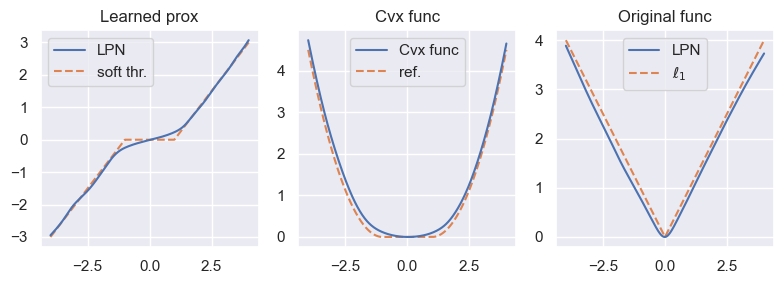

In [29]:
gamma_loss = 0.3

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.2

iteration 0 loss 0.8135915398597717
iteration 500 loss 0.8042107224464417
iteration 1000 loss 0.8012149930000305
iteration 1500 loss 0.8108922243118286
iteration 2000 loss 0.8018621206283569
iteration 2500 loss 0.7994023561477661
iteration 3000 loss 0.8121286630630493
iteration 3500 loss 0.8106088638305664
mse 5.344012260437012
mse 4.402534008026123
mse 1.0279738903045654
mse 0.24261412024497986
mse 0.06287380307912827
mse 0.013084331527352333
mse 0.0018097010906785727
mse 0.00017544839647598565
mse 1.2734029041894246e-05
mse 7.113013680282165e-07
final mse 3.1610660755632125e-08
(1000,) (1000,) (1000,) (1000,)


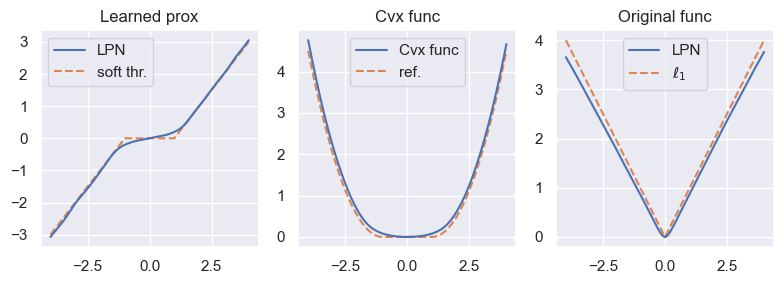

In [30]:
gamma_loss = 0.2

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.1

iteration 0 loss 0.9112570285797119
iteration 500 loss 0.8962922692298889
iteration 1000 loss 0.8957589268684387
iteration 1500 loss 0.9039543271064758
iteration 2000 loss 0.90749591588974
iteration 2500 loss 0.8905038833618164
iteration 3000 loss 0.8991221785545349
iteration 3500 loss 0.8978211879730225
mse 5.344015121459961
mse 4.5104146003723145
mse 1.0258344411849976
mse 0.26703187823295593
mse 0.0663890391588211
mse 0.013459128327667713
mse 0.001956918742507696
mse 0.00021643897343892604
mse 1.9491622879286297e-05
mse 1.4612872973884805e-06
final mse 9.38152240337331e-08
(1000,) (1000,) (1000,) (1000,)


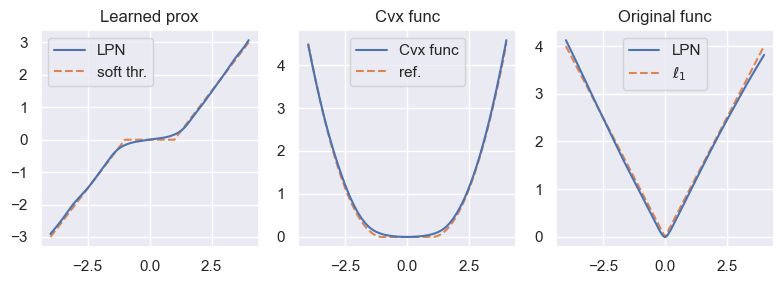

In [31]:
gamma_loss = 0.1


for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma = 0.05

iteration 0 loss 0.9472426176071167
iteration 500 loss 0.9479466676712036
iteration 1000 loss 0.933577835559845
iteration 1500 loss 0.950869083404541
mse 5.344011306762695
mse 4.509228706359863
mse 1.0278047323226929
mse 0.2675027847290039
mse 0.0675821304321289
mse 0.013773568905889988
mse 0.00204673083499074
mse 0.00023398046323563904
mse 2.190177474403754e-05
mse 1.7103649270211463e-06
final mse 1.1411162859076285e-07
(1000,) (1000,) (1000,) (1000,)


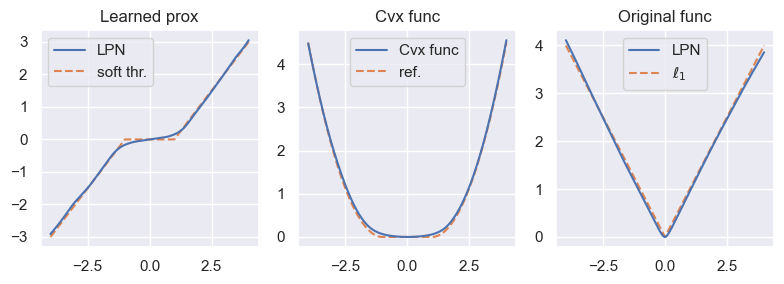

In [32]:
gamma_loss = 0.05

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(2000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)